In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [7]:
%%time
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['Z3','Q','PS','PBLH','T','U','V','U10','PSL','OMEGA']+tracer_3d

diri = os.path.join(dataroot,'orcas','cesm_flight_data')
model_files = [os.path.join(diri,'.'.join([case,os.path.basename(f)])) 
              for f in gv.flight_file]

obs = xr.open_mfdataset(gv.flight_file)
mdl = xr.open_mfdataset(model_files)

obs['GGALT'] = obs.GGALT * 1e-3
obs.GGALT.attrs['units'] = 'km'
obs = obs.drop(['UTC','DOY'])

mdl['GGALT'] = obs.GGALT.copy()
mdl['GGLAT'] = obs.GGLAT.copy()
mdl['GGLON'] = obs.GGLON.copy()
mdl = mdl.drop(['UTC','DOY'])
mdl.info()

xarray.Dataset {
dimensions:
	time = 34205 ;

variables:
	datetime64[ns] time(time) ;
	float64 O2_OCN(time) ;
		O2_OCN:units = per meg ;
		O2_OCN:long_name = O2_OCN ;
	float64 CO2_T09k(time) ;
		CO2_T09k:units = ppmv ;
		CO2_T09k:long_name = Takahashi (Dec x -150%) ;
	float64 aO2_GKA(time) ;
		aO2_GKA:units = per meg ;
		aO2_GKA:long_name = GK2001 (abiotic) ;
	float64 CO2_C15O(time) ;
		CO2_C15O:units = ppmv ;
		CO2_C15O:long_name = CT2015 (ocean) ;
	float64 CO2_LND(time) ;
		CO2_LND:units = ppmv ;
		CO2_LND:long_name = CO2_LND ;
	float64 U10(time) ;
		U10:units = m/s ;
		U10:long_name = 10m wind speed ;
		U10:cell_methods = time: mean ;
	float64 CO2_T09(time) ;
		CO2_T09:units = ppmv ;
		CO2_T09:long_name = Takahashi (2009) ;
	float64 PS(time) ;
		PS:units = hPa ;
		PS:long_name = Surface pressure ;
		PS:cell_methods = time: mean ;
	float64 CO2_T09b(time) ;
		CO2_T09b:units = ppmv ;
		CO2_T09b:long_name = Takahashi (Jan x +50%) ;
	float64 CO2_T09c(time) ;
		CO2_T09c:units = ppmv ;
		C

### Apply a mask to avoid land and points north of latitude boundary

mask points over land

In [9]:
lat_rgn = [-90.,-44]
lon_rgn = [-180.,180.]

named_points = {
    'SCCI' : [-53.01062,-70.85168,42],
    'SCAR' : [-18.3483,-70.3386, 167],
    'SCTE' : [-41.438611, -73.0939, 294],
    'SCVD' : [-39.649722,-73.086111,59]}

airport_lon = np.array([v[1] for v in named_points.values()])
airport_lat = np.array([v[0] for v in named_points.values()])

def region_quality_mask(x,y,z):
    from earth_geometry import points_in_range

    #-- land_mask = within 10km of airport and below 4 km
    land_mask = ~( (points_in_range(airport_lon,airport_lat,x,y,10.)) & (z < 4.) )

    #-- region_mask 
    region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )

    return ( land_mask & region_mask )


Verify application of mask: points in orange are included, points in blue have been removed

/Users/mclong/Dropbox/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/Users/mclong/Dropbox/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/Users/mclong/Dropbox/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


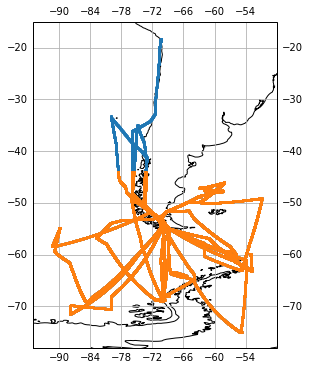

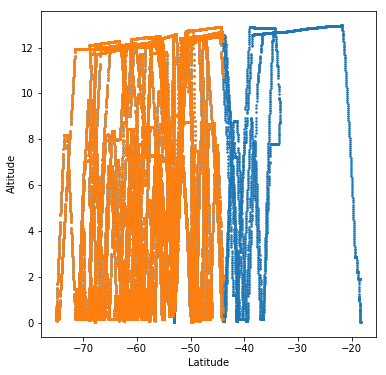

In [10]:
fig = plt.figure(figsize=(6,6))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(111,projection=crs_latlon)
ax.set_extent([-95,-48,-78,-15],crs=crs_latlon)
ax.coastlines('50m')
ax.gridlines(draw_labels=True)

ax.plot(mdl.GGLON,mdl.GGLAT,'.',markersize=3,transform=crs_latlon)
ds = mdl.where(region_quality_mask(mdl.GGLON.values,mdl.GGLAT.values,mdl.GGALT.values))
ax.plot(ds.GGLON,ds.GGLAT,'.',markersize=3,transform=crs_latlon)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(mdl.GGLAT,mdl.GGALT,'.',markersize=3)
ax.plot(ds.GGLAT,ds.GGALT,'.',markersize=3)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude')

Apply the mask

In [11]:
mdl = mdl.where(region_quality_mask(mdl.GGLON.values,mdl.GGLAT.values,mdl.GGALT.values))
obs = obs.where(region_quality_mask(obs.GGLON.values,obs.GGLAT.values,obs.GGALT.values))

/Users/mclong/Dropbox/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/Users/mclong/Dropbox/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/Users/mclong/Dropbox/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


### bin the data into altitude bins

In [14]:
%%time
alt_bins = np.concatenate((np.arange(0.,1.,0.25),np.arange(1.,14.5,0.5)))
alt_bin_c = np.vstack((alt_bins[0:-1],alt_bins[1:])).mean(axis=0)

groups = mdl.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
mdl_avg = groups.mean()
mdl_std = groups.std()

groups = obs.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
obs_avg = groups.mean()
obs_std = groups.std()
  
mdl_avg.info()

xarray.Dataset {
dimensions:
	GGALT_bins = 30 ;

variables:
	float64 GGALT_bins(GGALT_bins) ;
	float64 O2_OCN(GGALT_bins) ;
	float64 CO2_T09k(GGALT_bins) ;
	float64 aO2_GKA(GGALT_bins) ;
	float64 CO2_C15O(GGALT_bins) ;
	float64 CO2_LND(GGALT_bins) ;
	float64 U10(GGALT_bins) ;
	float64 CO2_T09(GGALT_bins) ;
	float64 PS(GGALT_bins) ;
	float64 CO2_T09b(GGALT_bins) ;
	float64 CO2_T09c(GGALT_bins) ;
	float64 CO2_T09d(GGALT_bins) ;
	float64 CO2_T09e(GGALT_bins) ;
	float64 CO2_T09f(GGALT_bins) ;
	float64 CO2_T09g(GGALT_bins) ;
	float64 CO2_T09h(GGALT_bins) ;
	float64 CO2_T09i(GGALT_bins) ;
	float64 CO2_T09j(GGALT_bins) ;
	float64 CO2_CROF(GGALT_bins) ;
	float64 CO2_T09l(GGALT_bins) ;
	float64 CO2_OCN(GGALT_bins) ;
	float64 CO2_CROT(GGALT_bins) ;
	float64 Pm(GGALT_bins) ;
	float64 OMEGA(GGALT_bins) ;
	float64 CO2_L14C(GGALT_bins) ;
	float64 Z3(GGALT_bins) ;
	float64 PBLH(GGALT_bins) ;
	float64 CO2_T09a(GGALT_bins) ;
	float64 CO2_CROO(GGALT_bins) ;
	float64 Q(GGALT_bins) ;
	float64 U(GGALT_bins

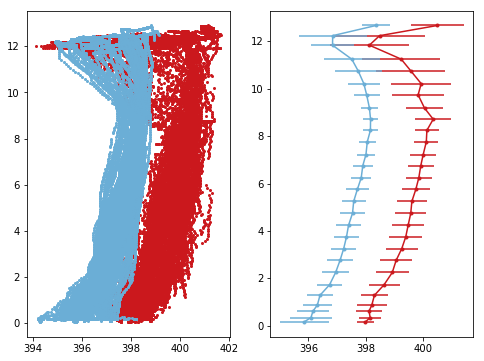

In [16]:
import colorbrewer
fig = plt.figure(figsize=(8.,6.))
vm = 'CO2'
vo = 'CO2_NOAA'
color_mdl = colorbrewer.singlehue('blue')[4]
color_obs = colorbrewer.singlehue('red')[2]

ax = fig.add_subplot(121)
sc = ax.plot(obs[vo],obs.GGALT,'.',markersize=4,color=color_obs)
sc = ax.plot(mdl[vm],mdl.GGALT,'.',markersize=4,color=color_mdl)

ax = fig.add_subplot(122)
sc = ax.errorbar(obs_avg[vo].values,obs_avg.GGALT.values,
                 xerr=obs_std[vo].values,
                 fmt='.-',color=color_obs)
sc = ax.errorbar(mdl_avg[vm].values,mdl_avg.GGALT.values,
                 xerr=mdl_std[vm].values,
                 fmt='.-',color=color_mdl)


### did we capture zonal mean properties?

Read dataset created by calc_so_ocean_campaign_mean.ipynb 

In [17]:
ds = xr.open_dataset(os.path.join(diro['out'],'.'.join([case,'so-ocean-mean-campaign','nc'])))
ds

IOError: No such file or directory

In [ ]:
fig = plt.figure(figsize=(4.,6.))
vm = 'CO2'
ax = fig.add_subplot(111)
ax.plot(ds.CO2.mean(dim='time'),ds.plev*1e-3)
sc = ax.errorbar(mdl_avg[vm].values,mdl_avg.GGALT.values,xerr=mdl_std[vm].values,fmt='.-')
ax.set_xlim(394.5,399.5)
ax.set_ylim(-0.5,13.3)

ax.set_ylabel('Altitude [km]')
ax.set_xlabel('CO$_2$ [ppm]')

### Where is air coming from and how long did it take to get there?

In [62]:
for v in sorted(mdl.variables):
    if 'IDL' in v:
        print('{sname}: {long_name}'.format(sname=v,long_name=mdl[v].attrs['long_name']))

IDL_S001: Land (except Antarctic)
IDL_S002: Anarctica
IDL_S003: Ocean 90N-30S
IDL_S004: Ocean 30S-45S
IDL_S005: Ocean 45S-60S
IDL_S006: Ocean 60S-90S
IDL_T000: Age of air
IDL_T001: Age of air (Land, except Antarctic)
IDL_T002: Age of air (Anarctica)
IDL_T003: Age of air (Ocean 90N-30S)
IDL_T004: Age of air (Ocean 30S-45S)
IDL_T005: Age of air (Ocean 45S-60S)
IDL_T006: Age of air (Ocean 60S-90S)


Aggregate some of these tracers into a smaller set of regions

In [174]:
#-- southern ocean (S of 45S) plus antarctica
so_avg = mdl_avg.IDL_S005 + mdl_avg.IDL_S006 + mdl_avg.IDL_S002
so_std = np.sqrt(mdl_std.IDL_S005**2 + mdl_std.IDL_S006**2 + mdl_std.IDL_S002**2)

#-- ocean north of 45S
no_avg = mdl_avg.IDL_S003 + mdl_avg.IDL_S004
no_std = np.sqrt(mdl_std.IDL_S003**2 + mdl_std.IDL_S004**2)

#-- land (except antarctica)
land_avg = mdl_avg.IDL_S001
land_std = mdl_std.IDL_S001

#-- age 
age_total_avg = mdl_avg.IDL_T000 * 365.
age_total_std = mdl_std.IDL_T000 * 365.

alt = mdl_avg.GGALT

#### age of air tracers

Age of air tracer.  I screwed up the boundary conditions for the regional age tracers in `bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004`.  These should sum to the total age, but rather than specifying a surface boundary condition of 0, I mistakenely specified a within-region boundary condition of 1, and 0 out of the region.  Thus, it is possible to reconstruct total age + 1, but the regional age tracers are hard to interpret individually.

The total age (`IDL_T000`, $A$) should be the sum of the regional age tracers (`IDL_T00N`, $\phi$):

$A = \sum \phi$

and the regional age ($A_i$) should be the regional age tracer divided by the regional provenance fraction (`IDL_S00N`):

$A_i = \frac{\phi}{f_i}$

Demonstrate the consistency with total and regional summed age below.

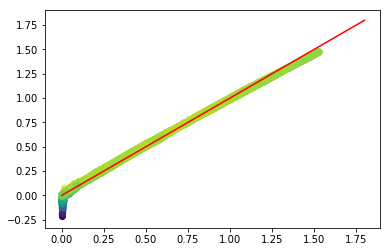

In [170]:
age = xr.full_like(mdl.IDL_T000,fill_value=0.)
frac = xr.full_like(mdl.IDL_T000,fill_value=0.)
for i in range(1,7):
    fraci = mdl['IDL_S{:03d}'.format(i)]
    agei = mdl['IDL_T{:03d}'.format(i)]
    frac += fraci
    age += agei

correction = 1.
    
plt.scatter(mdl.IDL_T000,age-correction,c=frac)
ylm = plt.gca().get_ylim()
plt.plot((0,1.8),(0,1.8),'r-')

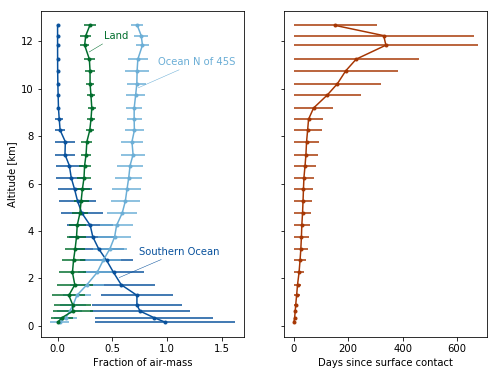

In [185]:
fig = plt.figure(figsize=(8.,6.))

color_so = colorbrewer.singlehue('blue')[1]
color_nh = colorbrewer.singlehue('blue')[4]
color_land = colorbrewer.singlehue('green')[1]
color_age = colorbrewer.singlehue('orange')[1]

ax = fig.add_subplot(121)
sc = ax.errorbar(so_avg.values,alt.values,
                 xerr=so_std.values,
                 fmt='.-',color=color_so)

sc = ax.errorbar(no_avg.values,alt.values,
                 xerr=no_std.values,
                 fmt='.-',color=color_nh)

sc = ax.errorbar(land_avg.values,alt.values,
                 xerr=land_std.values,
                 fmt='.-',color=color_land)


ax.set_ylabel('Altitude [km]')
ax.set_xlabel('Fraction of air-mass')

#-- Label NH ocean
y = 10.
x = np.interp(y,alt.values,no_avg.values)
ax.annotate('Ocean N of 45S', 
            xy=(x,y), 
            xytext=(x+0.2,y+1),
            color=color_nh,
            arrowprops=dict(color=color_nh,arrowstyle='-',linewidth=0.5),
            )

#-- Label Southern Ocean
y = 2.
x = np.interp(y,alt.values,so_avg.values)
ax.annotate('Southern Ocean', 
            xy=(x,y), 
            xytext=(x+0.2,y+1),
            color=color_so,
            arrowprops=dict(color=color_so,arrowstyle='-',linewidth=0.5),
            )

#-- Label Land
y = 11.5
x = np.interp(y,alt.values,land_avg.values)
ax.annotate('Land', 
            xy=(x,y), 
            xytext=(x+0.15,y+0.6),
            color=color_land,
            arrowprops=dict(color=color_land,arrowstyle='-',linewidth=0.5),
            )


ax = fig.add_subplot(122)
sc = ax.errorbar(age_total_avg.values,alt.values,
                 xerr=age_total_avg.values,
                 fmt='.-',color=color_age)
ax.set_yticklabels([])
ax.set_xlabel('Days since surface contact')

plt.savefig(os.path.join(diro['fig'],'vertical-profile-air-provenance-age.png'),
           bbox_inches='tight',dpi=300)

### check sum of CO2 flavors against total

The nonlinear transport means that the sum cannot be constructed exactly. 

CO$_{2}$ tracers were initialized with a constant mixing ratio of 360 ppm, thus I would expect to require that offset to match the total CO$_{2}$.  

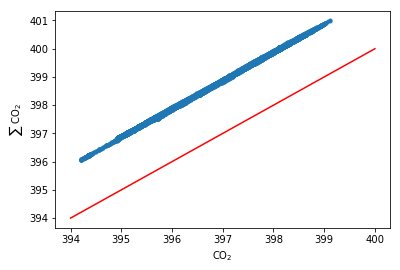

In [138]:
plt.plot(mdl.CO2,mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF+360.,'.')
plt.plot((394,400),(394,400),'r-')
plt.gca().set_xlabel('CO$_2$')
plt.gca().set_ylabel('$\sum$ CO$_2$')

That doesn't quite work.  Let's compute the optimal offset.

In [140]:
offset = (mdl.CO2 - (mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF)).mean().values
offset

array(358.119006699359)

Why is that different from 360.?  Perhaps there was an issue with precision?  Does the ratio with respect to 360 appear meaningful?

In [142]:
offset/360.

0.99477501860933049

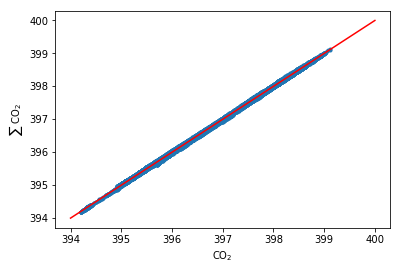

In [143]:
plt.plot(mdl.CO2,mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF+offset,'.')
plt.plot((394,400),(394,400),'r-')
plt.gca().set_xlabel('CO$_2$')
plt.gca().set_ylabel('$\sum$ CO$_2$')

### Methane distributions

Load up some data from NOAA ESRL: marine boundary layer CH4 obs.

In [200]:
import pandas
mblch4 = pandas.read_table('data/ch4_GHGreference.664228799_zonal.txt',comment='#',header=None,
                     names=('year','month','day','decimal_date','value','uncertainty'),
                     delim_whitespace=True).to_xarray()
mblch4

<xarray.Dataset>
Dimensions:       (index: 385)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    year          (index) int64 2009 2009 2009 2009 2009 2009 2009 2009 2009 ...
    month         (index) int64 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 ...
    day           (index) int64 1 8 16 23 31 8 15 23 2 10 18 25 2 9 17 25 2 ...
    decimal_date  (index) float64 2.009e+03 2.009e+03 2.009e+03 2.009e+03 ...
    value         (index) float64 1.735e+03 1.732e+03 1.731e+03 1.729e+03 ...
    uncertainty   (index) float64 1.041 1.026 1.079 1.183 1.292 1.367 1.379 ...

Fit a harmonic function to the data: 

$y=a+b∗t+c∗cos(2\pi t+d)$

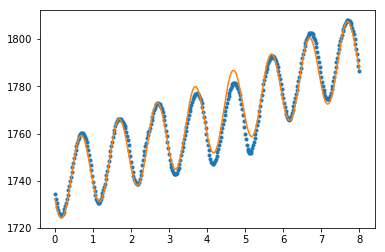

In [275]:
from scipy.optimize import curve_fit

func = lambda t,a,b,c,d: a + b * t + c * np.cos(2.*np.pi*t + d)

t = mblch4.decimal_date-mblch4.decimal_date[0]
abcd, pcov = curve_fit(func,t,mblch4.value.values)
plt.plot(t,mblch4.value,'.')
plt.plot(t,func(t,*abcd))

Plot mean seasonal cycle with ORCAS data

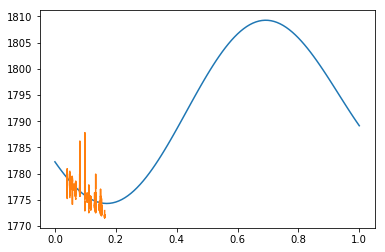

In [274]:
yearfrac = np.arange(0,1.01,0.01)
abcd_notrend = abcd.copy()
abcd_notrend[1] = 0.

plt.plot(yearfrac,func(yearfrac,*abcd)+50.)

ch4 = obs.CH4_NOAA.where(obs.THETA < 290.)

t = (ch4.time.values - np.datetime64('2016-01-01')) /  np.timedelta64(365,'D')
plt.plot(t,ch4)

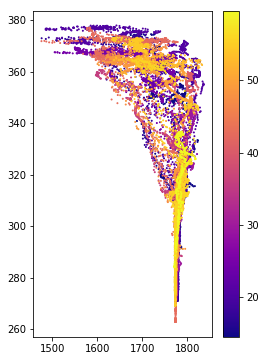

In [287]:
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)

t = (obs.time - np.datetime64('2016-01-01')) /  np.timedelta64(1,'D')
sc = ax.scatter(obs.CH4_NOAA,obs.THETA,c=t,s=1,cmap='plasma')
plt.colorbar(sc)
        

In [252]:
ch4.time

<xarray.DataArray 'time' (time: 34205)>
array(['2016-01-15T12:57:26.000000043', '2016-01-15T12:57:34.000000027',
       '2016-01-15T12:57:44.000000059', ..., '2016-02-29T19:37:43.999999920',
       '2016-02-29T19:37:53.999999953', '2016-02-29T19:38:00.000000098'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-15T12:57:26.000000043 ...